In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
# Import the BNS Paribas dataset from Kaggle
data=pd.read_csv('datasets/paribas.csv',nrows=50000)
data.shape

(50000, 133)

In [9]:
# Inpractise, feature selection should be done after data preprocessing
# So Ideally, all the categorical variables are enocded into numbers,
# and then you can assess whether they are correlated with other features

# here for simplicity I will use only numerical variables
# Select numerical columns
numericals=['int16','int32','int64','float16','float32','float64']
numerical_vars=list(data.select_dtypes(include=numericals).columns)
data=data[numerical_vars]
data.shape

(50000, 114)

In [11]:
# Splitting the dataset into training and testing to avoid Overfitting
x_train,x_test,y_train,y_test=train_test_split(data.drop(labels=['target'],axis=1),
                                              data['target'],test_size=0.3, random_state=0)
x_train.shape,x_test.shape

((35000, 113), (15000, 113))

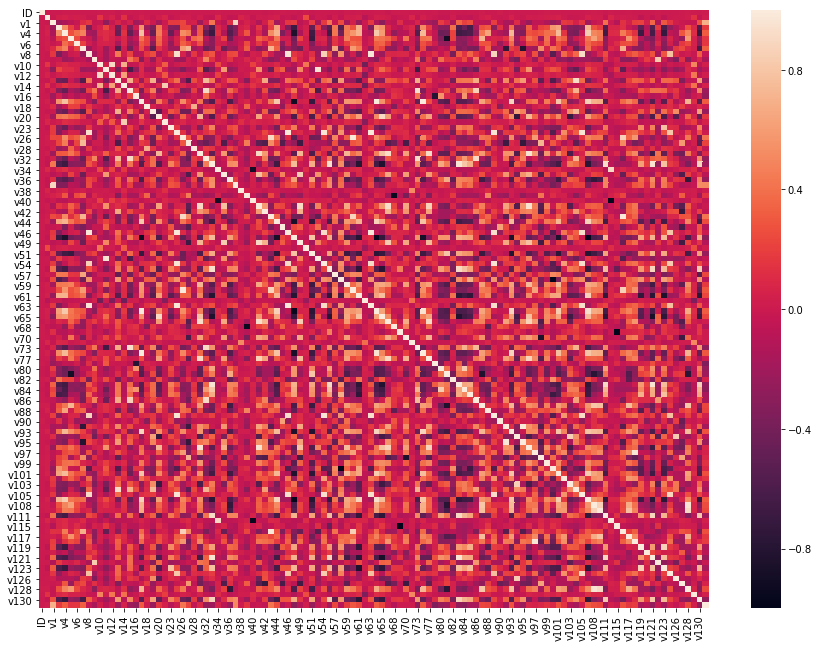

In [16]:
# Visualise Correlated features
# I will build the correlation matrix, which examines the
# correlation of all the features.
corrmat=data.corr()
fig,ax=plt.subplots()
fig.set_size_inches(15,11)
sns.heatmap(corrmat)

## Brute force approach

In [17]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any other insight, like which feature is correlated with which feature?

def correlation(dataset,threshold):
    col_corr=set()   # Set of all the names of correlated columns
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [19]:
corr_features=correlation(data,0.8)
len(set(corr_features))

# the later approach would be to remove the features from df

55

## Second Approach

In [42]:
# Investigates deeper to decide which feature to keep
# build the df with the correlation matrix
# remember the abs value of correlation coefficient is more important
corrmat=x_train.corr()
corrmat=corrmat.abs().unstack()  # absolute value, unstack means index col is added
corrmat=corrmat.sort_values(ascending=False)
corrmat=corrmat[corrmat>=0.8]
corrmat=corrmat[corrmat<1]       # corrmat is Series so far
corrmat=pd.DataFrame(corrmat).reset_index()
corrmat.columns=['Feature1','Feature2','Correlation']
corrmat.head()

,Feature1,Feature2,Correlation
0,v100,v58,0.997974
1,v58,v100,0.997974
2,v69,v115,0.993229
3,v115,v69,0.993229
4,v17,v76,0.992511


In [46]:
# find groups of correlated features
grouped_feature_ls=[]
correlated_groups=[]

for feature in corrmat.Feature1.unique():
    if feature not in grouped_feature_ls:
        
        # find all features correlated to a single feature
        correlated_block=corrmat[corrmat['Feature1']==feature]  # df with Feature1 == feature and all related features
        grouped_feature_ls=grouped_feature_ls+list(correlated_block.Feature2.unique())+[feature]
        
        # append the blocks of features to the list
        correlated_groups.append(correlated_block)
        
print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(x_train.shape[1]))

found 31 correlated groups
out of 113 total features


In [54]:
# now we can visualise each group. We see that some groups contains
# 2 correlated featues, some other groups present several features
# that are correlated among themselves

for group in correlated_groups:
    print(group)

  Feature1 Feature2  Correlation
0     v100      v58     0.997974
  Feature1 Feature2  Correlation
2      v69     v115     0.993229
    Feature1 Feature2  Correlation
4        v17      v76     0.992511
9        v17      v64     0.982145
106      v17      v48     0.910103
130      v17      v93     0.887841
174      v17     v106     0.854995
219      v17      v44     0.818050
242      v17     v101     0.800001
   Feature1 Feature2  Correlation
6       v46      v63     0.991521
11      v46      v25     0.982115
24      v46       v8     0.974733
59      v46     v105     0.944465
72      v46      v89     0.932504
88      v46      v54     0.918355
    Feature1 Feature2  Correlation
16       v60      v26     0.980037
148      v60      v43     0.872723
176      v60     v116     0.854290
   Feature1 Feature2  Correlation
18      v92      v95     0.978357
   Feature1 Feature2  Correlation
28     v114      v40     0.966750
98     v114      v34     0.911422
    Feature1 Feature2  Correlation
30   

In [58]:
# We can further investigate for particular group like say missing values
group=correlated_groups[2]
for feature in list(group.Feature2.unique())+['v17']:
    print(feature+' null values : {}'.format(x_train[feature].isnull().sum()))

v76 null values : 15275
v64 null values : 15275
v48 null values : 15275
v93 null values : 15288
v106 null values : 15275
v44 null values : 15275
v101 null values : 15275
v17 null values : 15275


In [62]:
# All features show similar number of missing values. 
# Hence we go for building a ML algo using all the features
# from the above list, and select the more predictive one.

features=list(group.Feature2.unique())+['v17']
rf=RandomForestClassifier(n_estimators=200,random_state=39,max_depth=4)
rf.fit(x_train[features].fillna(0),y_train)     # (understand the importance of RF here ???)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=39, verbose=0, warm_start=False)

In [63]:
# we get the feature importance attributed by the rf model

importance=pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)],axis=1)
importance.columns=['Features','Importance']
importance.sort_values(by=['Importance'],ascending=False)

,Features,Importance
2,v48,0.173981
3,v93,0.154484
6,v101,0.129764
1,v64,0.118110
7,v17,0.117571
4,v106,0.113958
0,v76,0.108071
5,v44,0.084062


#### Hence we can keep v48 and remove all other from the group.
#### The same can be done with the rest of the groups as well.